<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/class_gmm_em_expressions_cell_sizes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

In [70]:
## class version of using analytical and torch.optim updates

class GMM(object):

  def __init__(self, X, S, emu_c, smu_c, n_clusters=3, grad=False):
    self.X = torch.tensor(X)
    self.S = torch.tensor(S)
    self.emu_c = emu_c
    self.smu_c = smu_c

    # dimension
    self.n_obs, self.n_features = X.shape
    self.n_clusters = n_clusters

  #def initialization(self, grad=False):

    #torch.manual_seed(42)

    self.pi_d0 = torch.tensor(0.9)
      
    self.n_c = torch.tensor(self.n_obs / self.n_clusters).repeat(self.n_clusters)
    self.pi_c = self.n_c / self.n_obs
    #self.pi_c = torch.zeros(self.n_clusters).fill_(1. / (self.n_clusters))

    self.n_cc = torch.triu(torch.ones(self.n_clusters, self.n_clusters)) * torch.tensor(self.n_obs / self.n_clusters**2)
    self.n_cc[self.n_cc == 0] = float('NaN')
    self.pi_cc = self.n_cc / self.n_obs

    #self.pi_cc = torch.triu(torch.ones(self.n_clusters, self.n_clusters))
    #self.pi_cc = self.pi_cc / torch.sum(self.pi_cc)
    #self.pi_cc[self.pi_cc == 0] = float('NaN')

    self.log_post_d0 = torch.zeros(self.n_obs)
    self.log_post_d1 = torch.zeros(self.n_obs)
    self.log_post_z = torch.zeros(self.n_obs, self.n_clusters)
    self.log_post_g = torch.zeros(self.n_obs, self.n_clusters * self.n_clusters)
    self.log_post_dz = torch.zeros(self.n_obs, self.n_clusters)
    self.log_post_dg = torch.zeros(self.n_obs, self.n_clusters * self.n_clusters)

    self.eco_c = 0.1 * torch.eye(self.n_features).tile(self.n_clusters, 1, 1)
    self.sco_c = 0.1 * torch.ones(self.n_clusters, dtype=torch.float)

    self.smu_cc = torch.zeros(self.n_clusters, self.n_clusters, dtype=torch.float)
    self.sco_cc = torch.zeros(self.n_clusters, self.n_clusters, dtype=torch.float)

    self.emu_cc = torch.zeros(self.n_clusters, self.n_clusters, self.n_features, dtype=torch.float)
    self.eco_cc = torch.zeros(self.n_clusters, self.n_clusters, self.n_features, self.n_features, dtype=torch.float)

    for j in range(self.n_clusters):
      for k in range(self.n_clusters):
        self.smu_cc[j,k] = self.smu_c[j] + self.smu_c[k]
        self.sco_cc[j,k] = self.sco_c[j] + self.sco_c[k]

        self.emu_cc[j,k] = (self.emu_c[j] + self.emu_c[k])/2
        self.eco_cc[j,k] = (self.eco_c[j] + self.eco_c[k])/2

    if grad == True:

      device = 'cuda' if torch.cuda.is_available() else 'cpu'

      self.smu_c = torch.tensor(self.smu_c, requires_grad=True, dtype=torch.float, device=device)
      self.sco_c = torch.tensor(self.sco_c, requires_grad=True, dtype=torch.float, device=device)
      
      self.emu_c = torch.tensor(self.emu_c, requires_grad=True, dtype=torch.float, device=device)
      self.eco_c = torch.tensor(self.eco_c, requires_grad=True, dtype=torch.float, device=device)
      
      ####
      
      self.smu_cc = torch.tensor(self.smu_cc, requires_grad=True, dtype=torch.float, device=device)
      self.sco_cc = torch.tensor(self.sco_cc, requires_grad=True, dtype=torch.float, device=device)
      
      self.emu_cc = torch.tensor(self.emu_cc, requires_grad=True, dtype=torch.float, device=device)
      self.eco_cc = torch.tensor(self.eco_cc, requires_grad=True, dtype=torch.float, device=device)
      
      ####

  def _train(self, grad=False, n_epochs = 1000, tot = 1e-4):

    if grad:
      #parameters = [self.emu_c, self.eco_c, self.smu_c, self.sco_c]
      parameters = [self.emu_c, self.eco_c, self.smu_c, self.sco_c, self.emu_cc, self.eco_cc, self.smu_cc, self.sco_cc]
      #opt = optim.SGD(parameters, lr = 0.01)
      opt = optim.Adam(parameters, lr = 0.01)

    iter = 0
    llv = [0.0]
    while iter < n_epochs:
      
      if grad:
        loss = self._e_step(grad=True)
        self._m_stepO(parameters, opt, loss, tot)
      else:
        loss = self._e_step(grad=False)
        self._m_step()
    
      print('Iteration', iter + 1, 'Likelihood: ', -loss)

      if abs(llv[-1] + loss) < tot:
        break
      
      llv.append(-loss)
      iter += 1

    aic, bic = self._ics(-loss)
    return llv[1:], aic, bic

  def _trainT(self, n_epochs = 1000, lr = 0.01, tot = 1e-4):
    
    #parameters = [self.emu_c, self.eco_c, self.smu_c, self.sco_c]
    parameters = [self.emu_c, self.eco_c, self.smu_c, self.sco_c, self.emu_cc, self.eco_cc, self.smu_cc, self.sco_cc]
    opt = optim.SGD(parameters, lr=lr)
    #opt = optim.Adam(parameters)
    
    iter = 0
    llv = [0.0]
    while iter < n_epochs:
      loss = self._e_step()
      self._m_stepO(parameters, opt, loss, tot)

      print('Iteration', iter + 1, 'Likelihood: ', -loss)

      if abs(llv[-1] + loss) < tot:
        break
      
      llv.append(-loss)
      iter += 1

    aic, bic = self._ics(-loss)

    return llv[1:], aic, bic

  def _trainA(self, itermax=100, tot=1e-4):
    
    iter = 0
    llv = [0.0]
    while iter < itermax:
      loss = self._e_step()
      self._m_step()
      #print(self.emu_c)

      print('Iteration', iter + 1, 'Likelihood: ', -loss)

      if abs(llv[-1] + loss) < tot:
        break
      
      llv.append(-loss)
      iter += 1

    aic, bic = self._ics(-loss) #, X.shape[0], X.shape[1], len(pi_c))
    
    return llv[1:], aic, bic

  def _ics(self, logL): #, n, p, c
    params = ( (((self.n_features * self.n_features) - self.n_features)/2 + 2 * self.n_features + 3) * (((self.n_clusters * self.n_clusters) - self.n_clusters)/2 + 2 * self.n_clusters) ) - 1
    return 2 * (params - logL), -2 * logL + params * np.log(self.n_obs)

  def _e_step(self, grad=True):

    log_pi_d0 = torch.log(self.pi_d0)
    log_pi_d1 = torch.log(1 - self.pi_d0)

    log_pi_c = torch.log(self.pi_c)
    log_pi_cc = torch.log(self.pi_cc)

    ### E-step:
    log_post_top0 = torch.zeros(self.n_clusters, self.n_obs)
    log_post_top1 = torch.zeros(self.n_clusters, self.n_clusters, self.n_obs)

    for j in range(self.n_clusters):
  
      el0 = torch.distributions.MultivariateNormal(self.emu_c[j].float(), self.eco_c[j].float()).log_prob(self.X.float())
      sl0 = torch.distributions.Normal(self.smu_c[j].float(), self.sco_c[j].float()).log_prob(self.S.float())
      log_post_top0[j] = log_pi_d0 + log_pi_c[j] + el0 + sl0

      for k in range(self.n_clusters):
        if grad:
          el1 = torch.distributions.MultivariateNormal(self.emu_cc[j,k].float()/2, self.eco_cc[j,k].float()/2).log_prob(self.X.float())
          sl1 = torch.distributions.Normal(self.smu_cc[j,k].float(), self.sco_cc[j,k].float()).log_prob(self.S.float())
        else:
          el1 = torch.distributions.MultivariateNormal((self.emu_c[j] + self.emu_c[k]).float()/2, (self.eco_c[j] + self.eco_c[k]).float()/2).log_prob(self.X.float())
          #https://stats.stackexchange.com/questions/99363/mean-of-covariance-matrices
          #https://stats.stackexchange.com/questions/214174/calculating-the-covariance-matrix-for-the-mean-of-variables
          sl1 = torch.distributions.Normal((self.smu_c[j] + self.smu_c[k]).float(), (self.sco_c[j] + self.sco_c[k]).float()).log_prob(self.S.float())
        
        if torch.isnan(self.pi_cc[j,k]): #lower triangular nan
          log_post_top1[j,k] = float("-Inf")
        else:
          log_post_top1[j,k] = log_pi_d1 + log_pi_cc[j,k] + el1 + sl1

    log_post_bot0 = torch.logsumexp(log_post_top0, 0) #n
    self.log_post_z = (log_post_top0 - log_post_bot0).T #nxc (rjk)
    self.log_post_z[torch.isnan(self.log_post_z)] = 0

    log_post_top1 = log_post_top1.reshape(self.n_clusters * self.n_clusters, self.n_obs) #reshape
    log_post_bot1 = torch.logsumexp(log_post_top1, 0) #n
    self.log_post_g = (log_post_top1 - log_post_bot1).T #nxc (rijk)
    self.log_post_g[torch.isnan(self.log_post_g)] = 0

    bot = torch.exp(log_post_bot0) + torch.exp(log_post_bot1)

    bot[bot==0.0] = 1e-6
    bot = torch.log(bot)

    loss = -torch.mean(bot)

    self.log_post_d0 = log_post_bot0 - bot
    self.log_post_d1 = log_post_bot1 - bot

    self.log_post_dz = self.log_post_d0[:,None] + self.log_post_z
    self.log_post_dg = self.log_post_d1[:,None] + self.log_post_g

    return loss #, log_post_d0, log_post_d1, log_post_z, log_post_g, log_post_dz, log_post_dg

  def _m_stepO(self, params, opt, loss, tot):

    opt.zero_grad()
    loss.backward()
    opt.step()
      
    with torch.no_grad():
      params[0].clamp_(0)
      params[1].clamp_(tot)
      params[2].clamp_(0)
      params[3].clamp_(tot)
      params[4].clamp_(0)
      params[5].clamp_(tot)
      params[6].clamp_(tot)
      params[7].clamp_(0)

      r_ij = torch.exp(self.log_post_dz)
      self.n_c = torch.sum(r_ij, dim=0)
      self.pi_c = self.n_c / self.n_obs  # c values
    
      #assert(torch.isnan(pi_c).sum() == 0)
      r_ijk = torch.exp(self.log_post_dg).reshape(self.n_obs, self.n_clusters, self.n_clusters)
      self.n_cc = torch.sum(r_ijk, dim=0) # (cxc)
      self.pi_cc = self.n_cc / self.n_obs  # cxc matrix

      self.pi_d0 = torch.sum(torch.exp(self.log_post_d0)) / self.n_obs

  def _m_step(self):

    self.pi_d0 = torch.sum(torch.exp(self.log_post_d0)) / self.n_obs # one value

    r_ij = torch.exp(self.log_post_dz)
    self._estimate_mean_cov_t1v2(r_ij)
    #n_c, smu_c, sco_c, emu_c, eco_c = _estimate_mean_cov_t1v2(X, S, r_ij)
    self.pi_c = self.n_c / self.n_obs # c values

    indx = []
    for j in range(self.log_post_dg.shape[1]):
      if torch.sum(torch.isinf(self.log_post_dg[:,j])) == self.log_post_dg.shape[0]:
        indx.append(j)
    self.log_post_dg[:,indx] = float('NaN')

    r_ijk = torch.exp(self.log_post_dg).reshape(self.n_obs, self.n_clusters, self.n_clusters)
    self._estimate_mean_cov_t2v2(r_ijk)
    #n_cc, smu_cc, sco_cc, emu_cc, eco_cc = _estimate_mean_cov_t2v2(X, S, r_ijk)
    self.pi_cc = self.n_cc / self.n_obs  # cxc matrix  

    #return pi_d0, n_c, pi_c, emu_c, eco_c, smu_c, sco_c, n_cc, pi_cc, emu_cc, eco_cc, smu_cc, sco_cc

  def _estimate_mean_cov_t1v2(self, r_ij, reg=1e-6):

    self.n_c = torch.sum(r_ij, dim=0) + reg # (c)
    #print(self.n_c.sum())

    for j in range(self.n_clusters):
      e_n = torch.round(self.n_c[j])
      idx = r_ij[:,j].argsort()[-e_n.int():]
      self.smu_c[j] = torch.mean(self.S[idx], 0)
      self.emu_c[j] = torch.mean(self.X[idx], 0)
      if e_n > 1:
        self.sco_c[j] = torch.std(S[idx]) + reg
        self.eco_c[j] = torch.tensor(np.cov(self.X[idx].T, ddof=0)) + reg * torch.eye(self.n_features)
      else:
        self.eco_c[j] = reg * torch.eye(self.n_features)
        self.sco_c[j] = reg
    #return n_c, smut, scot, emut, ecot
  
  def _estimate_mean_cov_t2v2(self, r_ijk, reg=1e-6):
  
    self.n_cc = torch.sum(r_ijk, dim=0) + reg # (cxc)

    for j in range(self.n_clusters):
      for k in range(self.n_clusters):
        if not torch.isnan(self.n_cc[j,k]):
          e_n = torch.round(self.n_cc[j,k])
          idx = r_ijk[:,j,k].argsort()[-e_n.int():]
          self.smu_cc[j,k] = torch.mean(self.S[idx], 0)
          self.emu_cc[j,k] = torch.mean(self.X[idx], 0)
          if e_n > 1:
            self.sco_cc[j,k] = torch.std(self.S[idx]) + reg
            self.eco_cc[j,k] = torch.tensor(np.cov(self.X[idx].T, ddof=0)) + reg * torch.eye(self.n_features)
          else:
            self.sco_cc[j,k] = reg
            self.eco_cc[j,k] = reg * torch.eye(self.n_features)
    #return n_cc, smut, scot, emut, ecot 

In [71]:
## create data

n_clusters = 3
n_features = 2

## ground true expressions ##
true_expression_means = torch.tensor([
    [1, 2],
    [4, 3],
    [7, 9]
])

true_expression_covs = torch.tensor([
    [[.1, 0], [0, .1]],
    [[.1, 0], [0, .1]],
    [[.1, 0], [0, .1]]
])

true_size_means = torch.tensor([.4, .5, .6])

print(true_size_means)

true_size_stds = torch.tensor([.1, .05, .01])
true_size_stds

tensor([0.4000, 0.5000, 0.6000])


tensor([0.1000, 0.0500, 0.0100])

In [72]:
## other ground true for generating data ##
d_ws = torch.tensor([.95, .05])
z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])

N = 10000
gs = np.sum(np.random.choice(len(d_ws), size = N, p = d_ws))
zs = N - gs

In [5]:
## simulate data
x = np.zeros((zs, n_features+4))
for i in range(zs):
  z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
  x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, z+6])
  
xxx = np.zeros((gs, n_features+4))
for i in range(gs):

  g = np.random.choice(6, size = 1, p = g_ws)[0]
    
  if g == 0:
    idx = [0,0]
  elif g == 1:
    idx = [0,1]
  elif g == 2:
    idx = [0,2]
  elif g == 3:
    idx = [1,1]
  elif g == 4:
    idx = [1,2]
  else:
    idx = [2,2]
  
  xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[idx[0]] + true_expression_means[idx[1]])/2, (true_expression_covs[idx[0]] + true_expression_covs[idx[1]])/2 ),
                     [np.random.normal( (true_size_means[idx[0]] + true_size_means[idx[1]]), (true_size_stds[idx[0]] + true_size_stds[idx[1]]) ), 1, g, g])
  
xx = np.append(x, xxx).reshape(N,6)

In [ ]:
X = torch.tensor(xx[:,:2])
S = torch.tensor(xx[:,2])

emu_c = torch.tensor([
  [3, 5], # 1 2
  [4, 6],
  [6, 8], # 4 3
  [8, 10]
], dtype=torch.float) #, requires_grad=True,  device=device)

smu_c = torch.tensor([.2, .4, .6, .8], dtype=torch.float) #, requires_grad=True, dtype=torch.float, device=device)

gmm = GMM(X, S, emu_c, smu_c, n_clusters=4, grad=1)
lls, aic, bic = gmm._train(grad=1)

In [94]:
print(aic, bic) #c=2

tensor(80.5559, grad_fn=<MulBackward0>) tensor(361.7592, grad_fn=<AddBackward0>)


In [91]:
print(aic, bic) #c=3

tensor(144.4364, grad_fn=<MulBackward0>) tensor(656.3705, grad_fn=<AddBackward0>)


In [96]:
print(aic, bic) #c=4

tensor(223.2050, grad_fn=<MulBackward0>) tensor(1023.5528, grad_fn=<AddBackward0>)


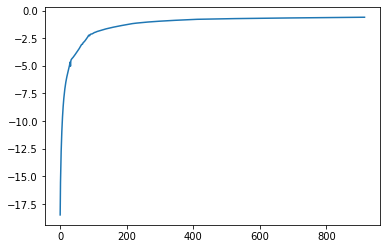

In [97]:
plt.plot(lls)

In [98]:
gmm.pi_d0

tensor(0.2504)

In [99]:
gmm.pi_c

tensor([0.0000e+00, 2.2317e-12, 2.3780e-01, 1.2600e-02])

In [100]:
gmm.pi_cc

tensor([[0.2311, 0.0034, 0.0000, 0.4785],
        [0.0000, 0.0129, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0237]])

In [101]:
gmm.emu_c

tensor([[3.1342, 4.8726],
        [4.1238, 5.8981],
        [7.0071, 8.9882],
        [6.9992, 9.0240]], requires_grad=True)

In [102]:
gmm.emu_cc

tensor([[[ 1.9936,  3.9934],
         [ 2.0320,  3.8564],
         [ 4.5891,  6.3981],
         [ 8.0117,  5.9767]],

        [[ 3.5000,  5.5000],
         [ 6.5175,  5.4534],
         [ 5.0795,  6.9174],
         [ 6.1003,  7.9040]],

        [[ 4.5000,  6.5000],
         [ 5.0000,  7.0000],
         [ 6.1003,  7.9040],
         [ 7.0680,  8.9579]],

        [[ 5.5000,  7.5000],
         [ 6.0000,  8.0000],
         [ 7.0000,  9.0000],
         [ 9.6386, 11.5447]]], requires_grad=True)

In [103]:
gmm.smu_c

tensor([0.3162, 0.5803, 0.6001, 1.1995], requires_grad=True)

In [104]:
gmm.smu_cc

tensor([[0.4010, 0.8655, 0.7208, 0.4986],
        [0.6000, 0.9517, 0.9207, 1.1027],
        [0.8000, 1.0000, 1.1027, 1.3241],
        [1.0000, 1.2000, 1.4000, 1.0478]], requires_grad=True)